# Online Contextual Bandits
** *
This IPython notebook illustrates the usage of the [contextualbandits](https://www.github.com/david-cortes/contextualbandits) package's `online` module through a simulation with public datasets.

** Small note: if the TOC here is not clickable or the math symbols don't show properly, try visualizing this same notebook from nbviewer following [this link](http://nbviewer.jupyter.org/github/david-cortes/contextualbandits/blob/master/example/online_contextual_bandits.ipynb). **

** *
### Sections 

[1. Problem description](#p1)

[2. Algorithms](#p2)

[3. Experiments](#p3)

* [3.1 Bibtext dataset](#p31)

* [3.2 Mediamill dataset](#p32)

[4. References](#p4)

** *
<a id="p1"></a>
## 1. Problem description

Contextual bandits, also known as multi-armed bandits with covariates or associative reinforcement learning, is a problem similar to multi-armed bandits, but with the difference that side information or covariates are available at each iteration and can be used to select an arm, whose rewards are also dependent on the covariates.
 

The problem comes from an iterative process generating data as follows:

* At each round, the world creates an observation consisting of a set of covariates $X$ of fixed dimension and a vector of rewards $r$ (which are stochastic but dependent on the covariates) of length corresponding to $m$, the number of arms.

* An agent must choose an arm or label for the observation among the set of $m$ arms.

* The world reveals the reward for the arm chosen by the agent, but not for the other arms.

The purpose is of course to build a policy that would maximize the rewards obtained by the agent. The arms might also expire over time and new arms might appear too, leading to the same exploration-exploitation dilemma faced in multi-armed bandits.

The problem is very similar to multi-class or multi-label classification (with the reward being whether the right label was chosen or not), but with the big difference that the right label or set of labels is not known for each observation, only whether the label that was chosen by the agent for each observation was correct or not.

Examples of such scenarios include online advertising, where we only know whether a user clicked an ad that he was presented with, but don't know which other ads he would have clicked; or clinic trials where we know how a person responded to a treatment, but don't know how he would have responded to a different treatment.

While, in general, algorithms for the contextual bandits problem assume continuous rewards in the range $r \in [0,1]$, **this package deals only with the case of discrete rewards $r \in \{0,1\}$.**
 

This IPython notebook in particular deals with the problem of building online algorithms that would work with little or no data, and which have to make a trade-off between exploring new or little-known arms or exploiting what's known to be good arms.

For the related problems of policy evaluation (determining how good is an algorithm given that we don't know the right labels for each observation) and off-policy learning (constructing better algorithms from data consisting of actions chosen by a different policy) see the other IPython notebooks [Off-policy Learning in Contextual Bandits](http://nbviewer.jupyter.org/github/david-cortes/contextualbandits/blob/master/example/offpolicy_learning.ipynb) and [Policy Evaluation in Contextual Bandits](http://nbviewer.jupyter.org/github/david-cortes/contextualbandits/blob/master/example/policy_evaluation.ipynb).

** *
<a id="p2"></a>
## 2. Algorithms 

 

The same high-level ideas from multi-armed bandits can be adapted to work with contextual bandits too, taking a binary classifier algorithm as a base or "oracle". These include:

* Upper-confidence bounds (a.k.a. "Optimism in the face of uncertainty"), consisting in taking an upper bound on the reward predicted for an arm. From this family, the package includes the algorithms `BootstrappedUCB`, `LinUCB`, and `BayesianUCB`. Note that the last two are not scalable to high-dimensional data, and thus not shown here.

* Thompson sampling, consisting in choosing an arm with probability proportional to it being the best arm. The implementations in this package include `BootstrappedTS`, `BayesianTS`, and `SoftmaxExplorer`. Note that the Bayesian approach is not scalable to high-dimensional data, and thus not shown here.

* Greedy exploration, consisting in choosing an arm at random sometimes so as to keep exploring. The implementation here is `EpsilonGreedy`. Other approaches such as epoch-greedy, while seemingly good in theory, don't seem to be competitive or perform well in practice, so I preferred to skip them.

* Adaptive exploration, consisting in choosing an arm according to models when we expect a reward with high certainty, and choosing another at random when not. The implementation here is `AdaptiveGreedy`.

* Explore-then-exploit, consisting in choosing arms at random until sufficient data is gathered, and then exploiting based on the information available.

Additionally, the package includes the heuristic `ActiveExplorer` based on "active learning", which tries to choose an observation according to its leverage on the model if its label were known; and `SeparateBandits`, which fits separate models for each arm with no guiding heuristic.

For more information see the documentation of each policy (e.g. you can try `help(contextualbandits.online.BootstrappedUCB`) and the references section at the end. Some of the policies here such as `AdaptiveGreedy` haven't been yet evaluated or described in any research papers for the scenario of contextual bandits though, and there might be better ways to convert the multi-armed bandits strategy to a contextual bandits strategy than how it was done here.

All of these heuristics are enhanced with an optional beta prior for arms for which not enough information to build a classifier is available, which will make predictions as random numbers drawn from a beta distribution with a pre-specified prior. In a cold-start scenario, the priors chosen a make a huge impact on the short- and middle-term performance of policies, even bigger than the heuristic chosen, so be careful to tune it properly.

 

All the policies/heuristics implemented here, except for `LinUCB`, `BayesianUCB` and `BayesianTS`, are meta-heuristics that take a binary classifier algorithm as a base in order to choose arms. Note that, unlike algorithms such as `LinUCB`, while they are meant for an online learning scenario, they still require to be refit with all the data each time rather than progrssively adding batches of data with a `partial_fit` method.

The classifier to pass to them must have a scikit-learn-like API (not necessarily fully scikit-learn-compatible) with `fit` and `decision_function` methods.

** *
<a id="p3"></a>
## 3. Experiments 

 

Data for contextual bandits is not easily available, and is hard to work with in terms of evaluation, but it is possible to turn any multi-label classification dataset into contextual bandits by revealing only the class for one label per observation. Doing this also has the advantage that we know also the rewards for all other arms when we want to evaluate a policy, but we can choose not to reveal them to the agent to simulate a real scenario. 
 

The experiments here consist in iterating over some multi-label datasets, letting each policy make choices as it passes through the data and observes rewards for the actions it chooses, and recording the reward that they receive – that is, whether the labels they choose were correct or not. The base classification algorithm used is logistic regression from scikit-learn's linear_model module.


The data used are the [Bibtex dataset](http://mlkd.csd.auth.gr/publication_details.asp?publicationID=278) see (_"Multilabel text classification for automated tag suggestion"_), containing tags that people have assigned to different papers (the goal being to learn to suggest tags based on features from the papers); and the [Mediamill dataset](https://ivi.fnwi.uva.nl/isis/mediamill/challenge/data.php) (see _"The Challenge Problem for Automated Detection of 101 Semantic Concepts in Multimedia"_), consisting in categories/labels for videos along with an embedded high-level representation of the video features (the goal being to assign the right label to a video given the features extracted from it). 

Both datasets are publicly available under the [Extreme Classification Repository](http://manikvarma.org/downloads/XC/XMLRepository.html)

<a id="p31"></a>
** *
### 3.1 Bibtex dataset

Loading the data - format is a sparse text file as used in libsvm and others, so it cannot be easily read with pandas:

In [1]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer

features=list()
labels=list()
with open('Bibtex_data.txt','rt') as f:
    f.readline()
    for l in f:
        if bool(re.search("^[0-9]",l)):
            g=re.search("^(([0-9]{1,2},?)+)\s(.*)$",l)
            labels.append([int(i) for i in g.group(1).split(",")])
            features.append(eval("{"+re.sub("\s",",",g.group(3))+"}"))
        else:
            l=l.strip()
            labels.append([])
            features.append(eval("{"+re.sub("\s",",",l)+"}"))
features=pd.DataFrame.from_dict(features).fillna(0).as_matrix()

mlb=MultiLabelBinarizer()
y=mlb.fit_transform(labels)
print(features.shape)
print(y.shape)

(7395, 1836)
(7395, 159)


Turning logistic regression into contextual bandits policies:

In [2]:
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import BootstrappedUCB, BootstrappedTS, SeparateClassifiers,\
            EpsilonGreedy, AdaptiveGreedy, ExploreFirst, ActiveExplorer, SoftmaxExplorer

nchoices=y.shape[1]

bootstrapped_ucb=BootstrappedUCB(base_algorithm=LogisticRegression(), nchoices=nchoices)
bootstrapped_ts=BootstrappedTS(base_algorithm=LogisticRegression(), nchoices=nchoices)
one_vs_rest=SeparateClassifiers(base_algorithm=LogisticRegression(), nchoices=nchoices)
epsilon_greedy=EpsilonGreedy(base_algorithm=LogisticRegression(), nchoices=nchoices)
epsilon_greedy_nodecay=EpsilonGreedy(base_algorithm=LogisticRegression(),
                                     nchoices=nchoices, decay=None)
adaptive_greedy_thr=AdaptiveGreedy(base_algorithm=LogisticRegression(), nchoices=nchoices,
                                   decay_type='threshold')
adaptive_greedy_perc=AdaptiveGreedy(base_algorithm=LogisticRegression(), nchoices=nchoices,
                                    decay_type='percentile', decay=0.9999)
explore_first=ExploreFirst(base_algorithm=LogisticRegression(), nchoices=nchoices, beta_prior=None)
explore_first_plus_prior=ExploreFirst(base_algorithm=LogisticRegression(), nchoices=nchoices,
                                      beta_prior=((3/nchoices,4),3))
active_explorer=ActiveExplorer(nchoices=nchoices)
softmax_explorer=SoftmaxExplorer(base_algorithm=LogisticRegression(), nchoices=nchoices)

_(Bayesian methods and LinUCB don't scale well enough for the dimensionality of the data, so they are not illustrated here)_

Now running the experiment:

In [3]:
# These lists will keep track of the rewards obtained by each policy
rewards_ucb=list()
rewards_ts=list()
rewards_ovr=list()
rewards_egr=list()
rewards_egr2=list()
rewards_agr=list()
rewards_agr2=list()
rewards_efr=list()
rewards_efr2=list()
rewards_ac=list()
rewards_sft=list()

# batch size - algorithms will be refit after N rounds
batch_size=50

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch=features[:batch_size,:]
action_chosen=np.random.randint(nchoices, size=batch_size)
rewards_received=y[np.arange(batch_size),action_chosen]

# fitting models for the first time
np.random.seed(123)
bootstrapped_ucb.fit(X=first_batch, a=action_chosen, r=rewards_received)
np.random.seed(123)
bootstrapped_ts.fit(X=first_batch, a=action_chosen, r=rewards_received)
np.random.seed(123)
one_vs_rest.fit(X=first_batch, a=action_chosen, r=rewards_received)
np.random.seed(123)
epsilon_greedy.fit(X=first_batch, a=action_chosen, r=rewards_received)
np.random.seed(123)
epsilon_greedy_nodecay.fit(X=first_batch, a=action_chosen, r=rewards_received)
np.random.seed(123)
adaptive_greedy_thr.fit(X=first_batch, a=action_chosen, r=rewards_received)
np.random.seed(123)
adaptive_greedy_perc.fit(X=first_batch, a=action_chosen, r=rewards_received)
np.random.seed(123)
explore_first.fit(X=first_batch, a=action_chosen, r=rewards_received)
np.random.seed(123)
explore_first_plus_prior.fit(X=first_batch, a=action_chosen, r=rewards_received)
np.random.seed(123)
active_explorer.fit(X=first_batch, a=action_chosen, r=rewards_received)
np.random.seed(123)
softmax_explorer.fit(X=first_batch, a=action_chosen, r=rewards_received)

# these lists will keep track of which actions does each policy choose
lst_a_ucb=action_chosen.copy()
lst_a_ts=action_chosen.copy()
lst_a_ovr=action_chosen.copy()
lst_a_egr=action_chosen.copy()
lst_a_egr2=action_chosen.copy()
lst_a_agr=action_chosen.copy()
lst_a_agr2=action_chosen.copy()
lst_a_efr=action_chosen.copy()
lst_a_efr2=action_chosen.copy()
lst_a_ac=action_chosen.copy()
lst_a_sft=action_chosen.copy()

# now running the loop
for i in range(int(np.floor(features.shape[0]/batch_size))):
    
    # determining data indexes for this batch
    st=(i+1)*batch_size
    end=(i+2)*batch_size
    end=np.min([end, features.shape[0]])
    data_batch=features[st:end,:]
    
    # letting each policy choose actions for this batch
    np.random.seed(i)
    actions_ucb=bootstrapped_ucb.predict(data_batch).astype('uint8')
    np.random.seed(i)
    actions_ts=bootstrapped_ts.predict(data_batch).astype('uint8')
    np.random.seed(i)
    actions_ovr=one_vs_rest.predict(data_batch).astype('uint8')
    np.random.seed(i)
    actions_egr=epsilon_greedy.predict(data_batch).astype('uint8')
    np.random.seed(i)
    actions_egr2=epsilon_greedy_nodecay.predict(data_batch).astype('uint8')
    np.random.seed(i)
    actions_agr=adaptive_greedy_thr.predict(data_batch).astype('uint8')
    np.random.seed(i)
    actions_agr2=adaptive_greedy_perc.predict(data_batch).astype('uint8')
    np.random.seed(i)
    actions_efst=explore_first.predict(data_batch).astype('uint8')
    np.random.seed(i)
    actions_efst2=explore_first_plus_prior.predict(data_batch).astype('uint8')
    np.random.seed(i)
    actions_active=active_explorer.predict(data_batch).astype('uint8')
    np.random.seed(i)
    actions_sft=softmax_explorer.predict(data_batch).astype('uint8')
    
    # keeping track of the sum of reward they receive
    rewards_ucb.append(y[np.arange(st,end),actions_ucb].sum())
    rewards_ts.append(y[np.arange(st,end),actions_ts].sum())
    rewards_ovr.append(y[np.arange(st,end),actions_ovr].sum())
    rewards_egr.append(y[np.arange(st,end),actions_egr].sum())
    rewards_egr2.append(y[np.arange(st,end),actions_egr2].sum())
    rewards_agr.append(y[np.arange(st,end),actions_agr].sum())
    rewards_agr2.append(y[np.arange(st,end),actions_agr2].sum())
    rewards_efr.append(y[np.arange(st,end),actions_efst].sum())
    rewards_efr2.append(y[np.arange(st,end),actions_efst2].sum())
    rewards_ac.append(y[np.arange(st,end),actions_active].sum())
    rewards_sft.append(y[np.arange(st,end),actions_sft].sum())
    
    # adding this batch to the history of selected actions
    lst_a_ucb=np.append(lst_a_ucb, actions_ucb)
    lst_a_ts=np.append(lst_a_ts, actions_ts)
    lst_a_ovr=np.append(lst_a_ovr, actions_ovr)
    lst_a_egr=np.append(lst_a_egr, actions_egr)
    lst_a_egr2=np.append(lst_a_egr2, actions_egr2)
    lst_a_agr=np.append(lst_a_agr, actions_agr)
    lst_a_agr2=np.append(lst_a_agr2, actions_agr2)
    lst_a_efr=np.append(lst_a_efr, actions_efst)
    lst_a_efr2=np.append(lst_a_efr2, actions_efst2)
    lst_a_ac=np.append(lst_a_ac, actions_active)
    lst_a_sft=np.append(lst_a_sft, actions_sft)
    
    # now refitting the algorithms after observing these new rewards
    X_up_to_batch=features[:end,:]
    
    np.random.seed(i)
    bootstrapped_ucb.fit(X_up_to_batch, lst_a_ucb, y[np.arange(end),lst_a_ucb])
    np.random.seed(i)
    bootstrapped_ts.fit(X_up_to_batch, lst_a_ts, y[np.arange(end),lst_a_ts])
    np.random.seed(i)
    one_vs_rest.fit(X_up_to_batch, lst_a_ovr, y[np.arange(end),lst_a_ovr])
    np.random.seed(i)
    epsilon_greedy.fit(X_up_to_batch, lst_a_egr, y[np.arange(end),lst_a_egr])
    np.random.seed(i)
    epsilon_greedy_nodecay.fit(X_up_to_batch, lst_a_egr2, y[np.arange(end),lst_a_egr2])
    np.random.seed(i)
    adaptive_greedy_thr.fit(X_up_to_batch, lst_a_agr, y[np.arange(end),lst_a_agr])
    np.random.seed(i)
    adaptive_greedy_perc.fit(X_up_to_batch, lst_a_agr2, y[np.arange(end),lst_a_agr2])
    np.random.seed(i)
    explore_first.fit(X_up_to_batch, lst_a_efr, y[np.arange(end),lst_a_efr])
    np.random.seed(i)
    explore_first_plus_prior.fit(X_up_to_batch, lst_a_efr2, y[np.arange(end),lst_a_efr2])
    np.random.seed(i)
    active_explorer.fit(X_up_to_batch, lst_a_ac, y[np.arange(end),lst_a_ac])
    np.random.seed(i)
    softmax_explorer.fit(X_up_to_batch, lst_a_sft, y[np.arange(end),lst_a_sft])

Visualizing results:

/home/david/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


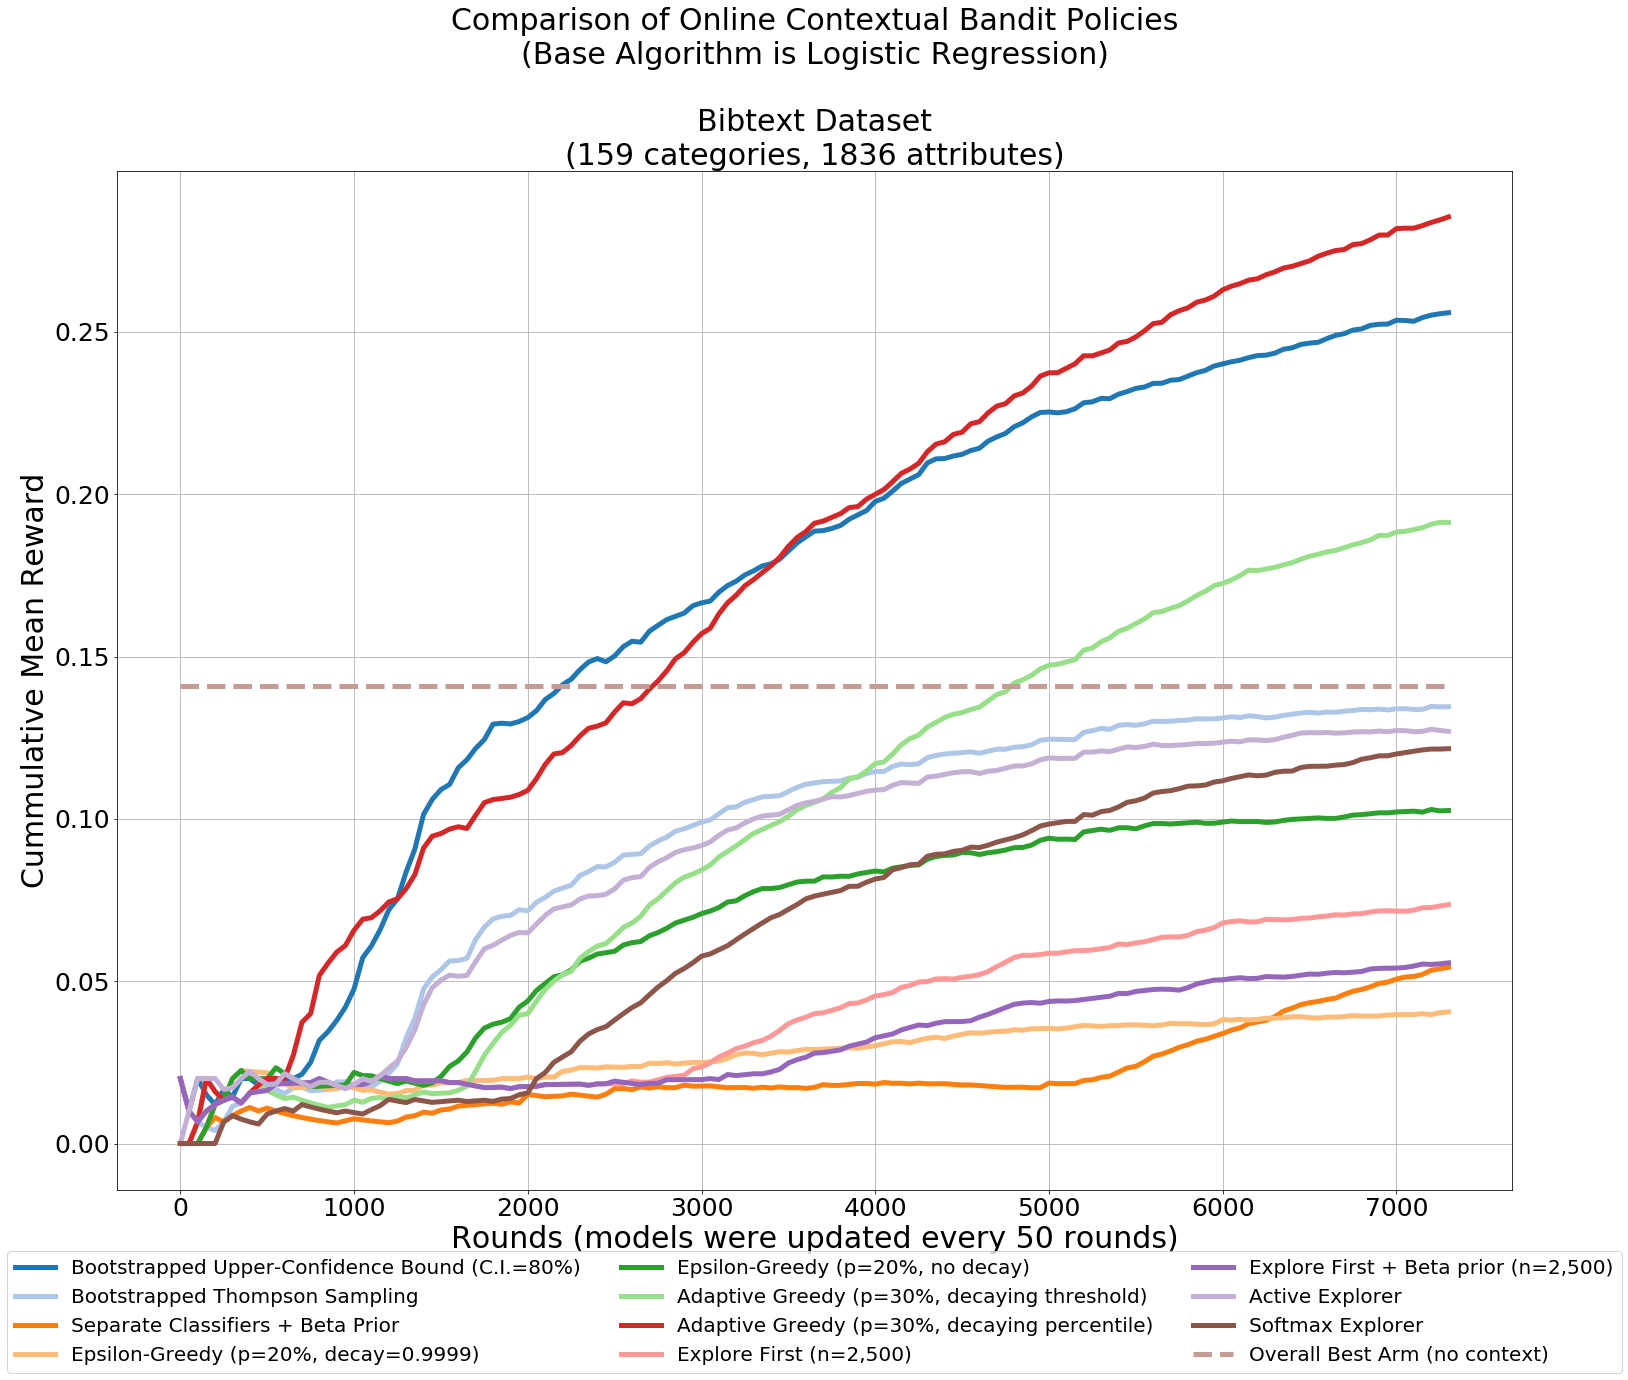

In [4]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1])/((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd=5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0,1,20))

plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper-Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_ts), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[1])
plt.plot(get_mean_reward(rewards_ovr), label="Separate Classifiers + Beta Prior",linewidth=lwd,color=colors[2])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p=20%, decay=0.9999)",linewidth=lwd,color=colors[3])
plt.plot(get_mean_reward(rewards_egr2), label="Epsilon-Greedy (p=20%, no decay)",linewidth=lwd,color=colors[4])
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (p=30%, decaying threshold)",linewidth=lwd,color=colors[5])
plt.plot(get_mean_reward(rewards_agr2), label="Adaptive Greedy (p=30%, decaying percentile)",linewidth=lwd,color=colors[6])
plt.plot(get_mean_reward(rewards_efr), label="Explore First (n=2,500)",linewidth=lwd,color=colors[7])
plt.plot(get_mean_reward(rewards_efr2), label="Explore First + Beta prior (n=2,500)",linewidth=lwd,color=colors[8])
plt.plot(get_mean_reward(rewards_ac), label="Active Explorer",linewidth=lwd,color=colors[9])
plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer",linewidth=lwd,color=colors[10])
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[11],ls='dashed')

ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)',size=30)
plt.ylabel('Cummulative Mean Reward',size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression)\n\nBibtext Dataset\n(159 categories, 1836 attributes)',size=30)
plt.grid()
plt.show()

<a id="p32"></a>
** *
### 3.1 Mediamill dataset

_(Copy-paste of the exact same code above used for Bibtex - just changing file name in this path, and later the batch size and number of rounds)_

This dataset is quite different from the previous one in that there is one label that most of the rows have, and selecting it always (as a context-free policy would do) is a very good options. In this case, it takes long for algorithms that explore too much to beat this bar.
** *
Loading the data - format is a sparse text file as used in libsvm and others, so it cannot be easily read with pandas:

In [5]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer

features=list()
labels=list()
with open('Mediamill_data.txt','rt') as f:
    f.readline()
    for l in f:
        if bool(re.search("^[0-9]",l)):
            g=re.search("^(([0-9]{1,2},?)+)\s(.*)$",l)
            labels.append([int(i) for i in g.group(1).split(",")])
            features.append(eval("{"+re.sub("\s",",",g.group(3))+"}"))
        else:
            l=l.strip()
            labels.append([])
            features.append(eval("{"+re.sub("\s",",",l)+"}"))
features=pd.DataFrame.from_dict(features).fillna(0).as_matrix()

mlb=MultiLabelBinarizer()
y=mlb.fit_transform(labels)
print(features.shape)
print(y.shape)

(43907, 120)
(43907, 101)


Initializing the objects with logistic regression:

In [6]:
nchoices=y.shape[1]

bootstrapped_ucb=BootstrappedUCB(base_algorithm=LogisticRegression(), nchoices=nchoices)
bootstrapped_ts=BootstrappedTS(base_algorithm=LogisticRegression(), nchoices=nchoices)
one_vs_rest=SeparateClassifiers(base_algorithm=LogisticRegression(), nchoices=nchoices)
epsilon_greedy=EpsilonGreedy(base_algorithm=LogisticRegression(), nchoices=nchoices)
epsilon_greedy_nodecay=EpsilonGreedy(base_algorithm=LogisticRegression(),
                                     nchoices=nchoices, decay=None)
adaptive_greedy_thr=AdaptiveGreedy(base_algorithm=LogisticRegression(),
                                   nchoices=nchoices, decay_type='threshold')
adaptive_greedy_perc=AdaptiveGreedy(base_algorithm=LogisticRegression(), nchoices=nchoices,
                                    decay_type='percentile', decay=0.9999)
explore_first=ExploreFirst(base_algorithm=LogisticRegression(), nchoices=nchoices,
                           explore_rounds=10000, beta_prior=None)
explore_first_plus_prior=ExploreFirst(base_algorithm=LogisticRegression(), nchoices=nchoices,
                                      explore_rounds=10000, beta_prior=((3/nchoices,4),3))
active_explorer=ActiveExplorer(nchoices=nchoices)
softmax_explorer=SoftmaxExplorer(base_algorithm=LogisticRegression(), nchoices=nchoices)

Now running the experiment:

In [7]:
# These lists will keep track of the rewards obtained by each policy
rewards_ucb=list()
rewards_ts=list()
rewards_ovr=list()
rewards_egr=list()
rewards_egr2=list()
rewards_agr=list()
rewards_agr2=list()
rewards_efr=list()
rewards_efr2=list()
rewards_ac=list()
rewards_sft=list()

# batch size - algorithms will be refit after N rounds
batch_size=100

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch=features[:batch_size,:]
action_chosen=np.random.randint(nchoices, size=batch_size)
rewards_received=y[np.arange(batch_size),action_chosen]

# fitting models for the first time
np.random.seed(123)
bootstrapped_ucb.fit(X=first_batch, a=action_chosen, r=rewards_received)
np.random.seed(123)
bootstrapped_ts.fit(X=first_batch, a=action_chosen, r=rewards_received)
np.random.seed(123)
one_vs_rest.fit(X=first_batch, a=action_chosen, r=rewards_received)
np.random.seed(123)
epsilon_greedy.fit(X=first_batch, a=action_chosen, r=rewards_received)
np.random.seed(123)
epsilon_greedy_nodecay.fit(X=first_batch, a=action_chosen, r=rewards_received)
np.random.seed(123)
adaptive_greedy_thr.fit(X=first_batch, a=action_chosen, r=rewards_received)
np.random.seed(123)
adaptive_greedy_perc.fit(X=first_batch, a=action_chosen, r=rewards_received)
np.random.seed(123)
explore_first.fit(X=first_batch, a=action_chosen, r=rewards_received)
np.random.seed(123)
explore_first_plus_prior.fit(X=first_batch, a=action_chosen, r=rewards_received)
np.random.seed(123)
active_explorer.fit(X=first_batch, a=action_chosen, r=rewards_received)
np.random.seed(123)
softmax_explorer.fit(X=first_batch, a=action_chosen, r=rewards_received)
# these lists will keep track of which actions does each policy choose
lst_a_ucb=action_chosen.copy()
lst_a_ts=action_chosen.copy()
lst_a_ovr=action_chosen.copy()
lst_a_egr=action_chosen.copy()
lst_a_egr2=action_chosen.copy()
lst_a_agr=action_chosen.copy()
lst_a_agr2=action_chosen.copy()
lst_a_efr=action_chosen.copy()
lst_a_efr2=action_chosen.copy()
lst_a_ac=action_chosen.copy()
lst_a_sft=action_chosen.copy()

# now running the loop
for i in range(300):
    
    # determining data indexes for this batch
    st=(i+1)*batch_size
    end=(i+2)*batch_size
    end=np.min([end, features.shape[0]])
    data_batch=features[st:end,:]
    
    # letting each policy choose actions for this batch
    np.random.seed(i)
    actions_ucb=bootstrapped_ucb.predict(data_batch).astype('uint8')
    np.random.seed(i)
    actions_ts=bootstrapped_ts.predict(data_batch).astype('uint8')
    np.random.seed(i)
    actions_ovr=one_vs_rest.predict(data_batch).astype('uint8')
    np.random.seed(i)
    actions_egr=epsilon_greedy.predict(data_batch).astype('uint8')
    np.random.seed(i)
    actions_egr2=epsilon_greedy_nodecay.predict(data_batch).astype('uint8')
    np.random.seed(i)
    actions_agr=adaptive_greedy_thr.predict(data_batch).astype('uint8')
    np.random.seed(i)
    actions_agr2=adaptive_greedy_perc.predict(data_batch).astype('uint8')
    np.random.seed(i)
    actions_efst=explore_first.predict(data_batch).astype('uint8')
    np.random.seed(i)
    actions_efst2=explore_first_plus_prior.predict(data_batch).astype('uint8')
    np.random.seed(i)
    actions_active=active_explorer.predict(data_batch).astype('uint8')
    np.random.seed(i)
    actions_sft=softmax_explorer.predict(data_batch).astype('uint8')
    
    # keeping track of the sum of reward they receive
    rewards_ucb.append(y[np.arange(st,end),actions_ucb].sum())
    rewards_ts.append(y[np.arange(st,end),actions_ts].sum())
    rewards_ovr.append(y[np.arange(st,end),actions_ovr].sum())
    rewards_egr.append(y[np.arange(st,end),actions_egr].sum())
    rewards_egr2.append(y[np.arange(st,end),actions_egr2].sum())
    rewards_agr.append(y[np.arange(st,end),actions_agr].sum())
    rewards_agr2.append(y[np.arange(st,end),actions_agr2].sum())
    rewards_efr.append(y[np.arange(st,end),actions_efst].sum())
    rewards_efr2.append(y[np.arange(st,end),actions_efst2].sum())
    rewards_ac.append(y[np.arange(st,end),actions_active].sum())
    rewards_sft.append(y[np.arange(st,end),actions_sft].sum())
    
    # adding this batch to the history of selected actions
    lst_a_ucb=np.append(lst_a_ucb, actions_ucb)
    lst_a_ts=np.append(lst_a_ts, actions_ts)
    lst_a_ovr=np.append(lst_a_ovr, actions_ovr)
    lst_a_egr=np.append(lst_a_egr, actions_egr)
    lst_a_egr2=np.append(lst_a_egr2, actions_egr2)
    lst_a_agr=np.append(lst_a_agr, actions_agr)
    lst_a_agr2=np.append(lst_a_agr2, actions_agr2)
    lst_a_efr=np.append(lst_a_efr, actions_efst)
    lst_a_efr2=np.append(lst_a_efr2, actions_efst2)
    lst_a_ac=np.append(lst_a_ac, actions_active)
    lst_a_sft=np.append(lst_a_sft, actions_sft)
    
    # now refitting the algorithms after observing these new rewards
    X_up_to_batch=features[:end,:]
    
    np.random.seed(i)
    bootstrapped_ucb.fit(X_up_to_batch, lst_a_ucb, y[np.arange(end),lst_a_ucb])
    np.random.seed(i)
    bootstrapped_ts.fit(X_up_to_batch, lst_a_ts, y[np.arange(end),lst_a_ts])
    np.random.seed(i)
    one_vs_rest.fit(X_up_to_batch, lst_a_ovr, y[np.arange(end),lst_a_ovr])
    np.random.seed(i)
    epsilon_greedy.fit(X_up_to_batch, lst_a_egr, y[np.arange(end),lst_a_egr])
    np.random.seed(i)
    epsilon_greedy_nodecay.fit(X_up_to_batch, lst_a_egr2, y[np.arange(end),lst_a_egr2])
    np.random.seed(i)
    adaptive_greedy_thr.fit(X_up_to_batch, lst_a_agr, y[np.arange(end),lst_a_agr])
    np.random.seed(i)
    adaptive_greedy_perc.fit(X_up_to_batch, lst_a_agr2, y[np.arange(end),lst_a_agr2])
    np.random.seed(i)
    explore_first.fit(X_up_to_batch, lst_a_efr, y[np.arange(end),lst_a_efr])
    np.random.seed(i)
    explore_first_plus_prior.fit(X_up_to_batch, lst_a_efr2, y[np.arange(end),lst_a_efr2])
    np.random.seed(i)
    active_explorer.fit(X_up_to_batch, lst_a_ac, y[np.arange(end),lst_a_ac])
    np.random.seed(i)
    softmax_explorer.fit(X_up_to_batch, lst_a_sft, y[np.arange(end),lst_a_sft])

Visualizing results:

/home/david/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


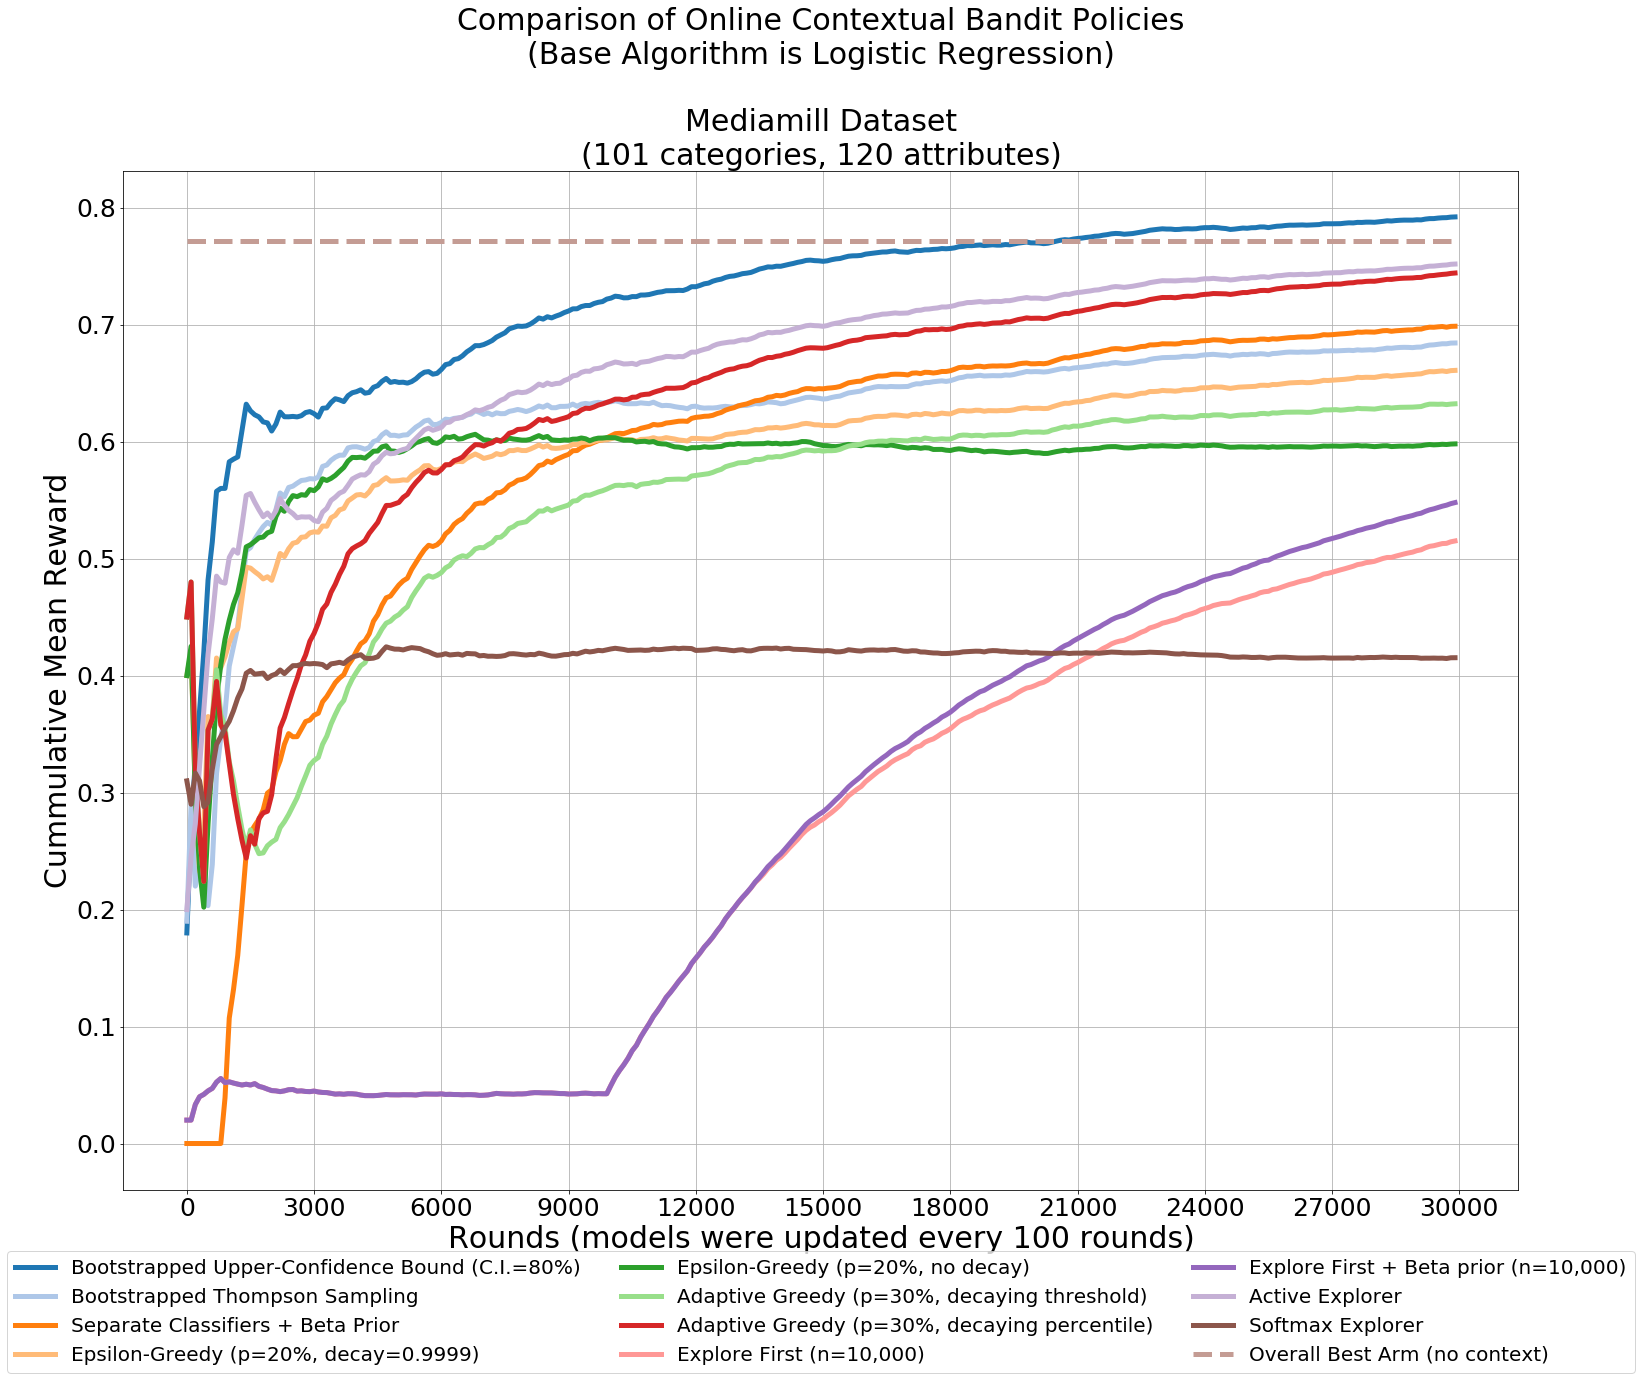

In [8]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1])/((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd=5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0,1,20))

plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper-Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_ts), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[1])
plt.plot(get_mean_reward(rewards_ovr), label="Separate Classifiers + Beta Prior",linewidth=lwd,color=colors[2])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p=20%, decay=0.9999)",linewidth=lwd,color=colors[3])
plt.plot(get_mean_reward(rewards_egr2), label="Epsilon-Greedy (p=20%, no decay)",linewidth=lwd,color=colors[4])
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (p=30%, decaying threshold)",linewidth=lwd,color=colors[5])
plt.plot(get_mean_reward(rewards_agr2), label="Adaptive Greedy (p=30%, decaying percentile)",linewidth=lwd,color=colors[6])
plt.plot(get_mean_reward(rewards_efr), label="Explore First (n=10,000)",linewidth=lwd,color=colors[7])
plt.plot(get_mean_reward(rewards_efr2), label="Explore First + Beta prior (n=10,000)",linewidth=lwd,color=colors[8])
plt.plot(get_mean_reward(rewards_ac), label="Active Explorer",linewidth=lwd,color=colors[9])
plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer",linewidth=lwd,color=colors[10])
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[11],ls='dashed')

ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*30 for i in range(11)], [i*100 for i in range(0,330,30)])

plt.xlabel('Rounds (models were updated every 100 rounds)',size=30)
plt.ylabel('Cummulative Mean Reward',size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression)\n\nMediamill Dataset\n(101 categories, 120 attributes)',size=30)
plt.grid()
plt.show()

<a id="p4"></a>
## 4. References
* Katakis, I., Tsoumakas, G., & Vlahavas, I. (2008, September). Multilabel text classification for automated tag suggestion. In Proceedings of the ECML/PKDD (Vol. 18).

* Snoek, C. G., Worring, M., Van Gemert, J. C., Geusebroek, J. M., & Smeulders, A. W. (2006, October). The challenge problem for automated detection of 101 semantic concepts in multimedia. In Proceedings of the 14th ACM international conference on Multimedia (pp. 421-430). ACM.

* Chapelle, O., & Li, L. (2011). An empirical evaluation of thompson sampling. In Advances in neural information processing systems (pp. 2249-2257).

* Agrawal, S., & Goyal, N. (2013, February). Thompson sampling for contextual bandits with linear payoffs. In International Conference on Machine Learning (pp. 127-135).

* Li, L., Chu, W., Langford, J., & Schapire, R. E. (2010, April). A contextual-bandit approach to personalized news article recommendation. In Proceedings of the 19th international conference on World wide web (pp. 661-670). ACM.

* Chakrabarti, D., Kumar, R., Radlinski, F., & Upfal, E. (2009). Mortal multi-armed bandits. In Advances in neural information processing systems (pp. 273-280).

* Vermorel, J., & Mohri, M. (2005, October). Multi-armed bandit algorithms and empirical evaluation. In European conference on machine learning (pp. 437-448). Springer, Berlin, Heidelberg.

* Yue, Y., Broder, J., Kleinberg, R., & Joachims, T. (2012). The k-armed dueling bandits problem. Journal of Computer and System Sciences, 78(5), 1538-1556.